## To be run with the 25 Ago commit on the main branch

In [1]:
from sevnpy.sevn import SEVNmanager,sevnwrap,Star
from sevnpy.io import readlogstring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as const
import astropy.units as u
import calclib as clib        # custom library with routines for tides, etc.
import plotlib as plib        # custom library with functions for plots
import os

# stellar table paths
sevn_version = 'sevn_25ago'
path_tables = f'/home/erika/Scrivania/uni/1-2dott/paper/GallegosGarciaLike/analysis/popsynth-comparison/{sevn_version}/sevn/tables/'
parsec_ov05 = path_tables + 'SEVNtracks_parsec_ov05_AGB'
MIST_robust = path_tables + 'SEVNtracks_MIST_AGBrobust'

path_plots = f'/home/erika/Scrivania/uni/1-2dott/paper/GallegosGarciaLike/analysis/popsynth-comparison/server/v_{sevn_version}/plot_grids'
os.makedirs(path_plots, exist_ok=True)

In [2]:
# grid setup
qgrid = np.linspace(0.1,1,50)     # mass ratio
Pgrid = np.logspace(0.0,3.5,50)      # period
m1 = 40                 # Msun, donor mass
Zs = [0.00142,0.000142]

In [3]:
def find_status(df):
    """
    Find the final status of the  binary  based on the results of the SEVN evolution
    (-1 Destroyed binary, 1 Merge within an Hubble time, 0 Not merge within an Hubble time)
    """
    CO = df['PhaseBSE_0'][-1]     # final status of the compact object
    BH = (int(CO) == 14)
    NS = (int(CO) == 13)
    WD = (int(CO) == 12 or int(CO) == 11 or int(CO) == 10)
    NotARemnant = (int(CO) == 15)    # it could happen as a result of a merger not flagged
    
    if np.isnan(df["GWtime"][-1]) or NotARemnant:
        return -1
    else:
        tdel= df["Worldtime"][-1] + df["GWtime"][-1]
        if (tdel<=14000) and BH:  # BBH merger
            return 1
        elif (tdel<=14000) and NS:  # BHNS merger
            return 13
        elif NS  == True:  # BHNS wide
            return 3
        elif (tdel<=14000) and WD:  # WDBH merger
            return 4
        elif WD == True :  # WDBH
            return 5
        else:           # BBH wide
            return 0



def find_label(df,log):
    """
    Find the formation channel based on the SEVN log and choose label for grid
    """
    st = find_status(df)

    alog=readlogstring(log,events=["CE","RLO_BEGIN","MERGER","COLLISION","SWALLOWED"],capturing_cols=("time","event"))
    dfCE=alog["CE"]
    dfRL=alog["RLO_BEGIN"]
    dfM=alog["MERGER"]
    dfC=alog["COLLISION"]
    dfS=alog["SWALLOWED"]
    surv = (len(dfM)==0 and len(dfC)==0 and len(dfS)==0 and st != -1)
    

    if len(dfRL)>0 and len(dfCE) ==0 and surv and st == 1 :
        return "BBHmSMT"
    elif len(dfCE)>0 and surv and st == 1:
        return "BBHmCE"
    elif st == 13 and surv:
        return "BHNSm"
    elif len(dfM)>0 or len(dfC)>0 or len(dfS)>0 or st ==-1:
        return "Merger"
    elif st == 3 and surv:
        return "BHNSwide"
    elif st == 4 and surv:
        return "BHWDm"
    elif st == 5 and surv:
        return "BHWDwide"
    else:
        return "BBHwide"




def calc_grid_single(m1, Zdonor, qgrid,Pgrid, SEVN_dict, stall_set=''): 
    # calculate grid of BH-MS 
    SEVNmanager.init(SEVN_dict)
    ql=[] # To store the mass-ratios
    pl=[] # To store the periods
    ll=[] # To store the label
    for p in Pgrid:
        for q in qgrid:
            m2 = q*m1
            a=plib.calc_a(p/365.25,m1,m2)
            
            #Evolve a binary initialising the second star as a BH
            if len(stall_set) == 0:    # no exception, run every q,p pair
                run = True
                df,ldic=sevnwrap.evolve_binary(a,0.,m1,Zdonor,m2,Zdonor,
                                                spin_0 = 0,
                                                star_flag_1="BH", snmodel='delayed')
            
            elif stall_set == 'Jeans_tides_qcrs':          # do not run endless critical binaries in SEVNpy as long as the check_stalling is disabled
                Z_stall = 0.000142
                q_stall, p_stall = 0.22857143, 1.17876863    # critical q and Period [days] for stalling binary
                if (abs(q-q_stall) < 1e-8) and (abs(p-p_stall) < 1e-8) and (abs(Zdonor-Z_stall) < 1e-8):
                    label_fate = "Merger"    # manually checked otside the wrapper that the binary merges
                    run = False
                else:
                    run = True
                    df,ldic=sevnwrap.evolve_binary(a,0.,m1,Zdonor,m2,Zdonor,
                                                   spin_0 = 0,
                                                   star_flag_1="BH", snmodel='delayed')
            else:
                run = False   # safety check
            
            if run == True:
                ll.append(find_label(df,ldic["Log"]))
            else:
                ll.append(label_fate)
            ql.append(q)
            pl.append(p)
    SEVNmanager.close()

    ql =  np.array(ql)
    pl =  np.array(pl)
    ll =  np.array(ll)

    return ql,pl,ll


def plot_grid_single(m1, Zdonor, qgrid,Pgrid, SEVN_dict, ax, text_input, type='gg',stall_set=''):
    ql,pl,ll = calc_grid_single(m1, Zdonor, qgrid,Pgrid, SEVN_dict, stall_set)

    idx=ll=="Merger"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="gold",marker="s",label=r"\textbf{Coalescence}")
    idx=ll=="BBHmSMT"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="blue",marker="s", hatch='xx',label=r"\textbf{BBH merger after SMT}")
    idx=ll=="BBHmCE"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="orange",marker="s", hatch ='xx', label=r"\textbf{BBH merger after CE}")
    idx=ll=="BBHwide"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="lightskyblue",marker="s",label=r"\textbf{BH-BH}")
    idx=ll=="BHNSwide"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="darkgrey",marker="s",label=r"\textbf{BH-NS}")
    idx=ll=="BHNSm"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="darkgrey",marker="s", hatch='xx')   # BHNS merger
    idx=ll=="BHWDwide"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="lightgrey",marker="s", label=r"\textbf{BH-WD}")
    idx=ll=="BHWDm"
    ax.scatter(ql[idx],np.log10(pl[idx]),c="lightgrey",marker="s", hatch='xx')   # BH-WD merger


    # add annotation on top
    ax.annotate(
    xy = (1,3.5),       # position of (invisible) arrow endpoint
    xytext = (1,3.5),   # position of text
    text=text_input,
    horizontalalignment = 'right',
    verticalalignment = 'top',
    weight = 'bold')
    ax.tick_params(axis='both', which='both',right='on',direction="inout", top="on", length=6,width=2)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1])


def plot_grid_multi8_2Z(m1, Zs, qgrid,Pgrid, SEVN_dict_list, text_input_list, savename, type='gg', stall_set=''):
    
    plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\boldmath",
    "font.family": "cmr10",   # computer modern font, as in latex
    "axes.formatter.use_mathtext": True,
    "font.size": 20,
    "font.weight": "bold",
    "axes.labelsize" : 20,
    "xtick.labelsize" : 20,
    "ytick.labelsize" : 20,
    "legend.fontsize": 19.5
    })

    nrows_subplots= 2
    ncols_subplots = 4
    fig=plt.figure(figsize=(16,21))   
    subfigs = fig.subfigures(nrows=3, ncols=1,height_ratios=[1,1,0.05])  # third row is the space for legend
    for subfig, Z in zip(subfigs,Zs):
        axs=subfig.subplots(nrows_subplots,ncols_subplots, sharex=True, sharey=True)
        subfig.suptitle(rf'$Z={Z}$', weight='bold')
        for i,ax, SEVN_dict, text_input in zip(np.arange(len(axs.flat)), axs.flat, SEVN_dict_list, text_input_list):
            # remove the "endless binary" only for the Jeans set (i=1) if all the other conditions are met
            if (stall_set == 'Jeans_tides_qcrs') and (Z==0.000142) and (i == 1):                    
                plot_grid_single(m1, Z, qgrid,Pgrid, SEVN_dict, ax, text_input, type,stall_set)
            else:
                plot_grid_single(m1, Z, qgrid,Pgrid, SEVN_dict, ax, text_input, type, stall_set = '')
                
        for nrow in np.arange(nrows_subplots):    
            axs[nrow][0].set_ylabel(r"$\log_{10} (P_{\rm orb, i}) $ \textbf{[days]}", weight='bold')                          
            for ncol in np.arange(ncols_subplots):            
                axs[nrows_subplots-1][ncol].set_xlabel(r"$q_{\rm i} = M_{\rm BH}$/$M_{\rm ZAMS}$",weight='bold')    
        axs[0][0].set_xlim(xmin = 0.07, xmax = 1.03)
        axs[0][0].set_ylim(ymin = -0.11, ymax = 3.61)
        subfig.subplots_adjust(bottom=0.08,left=0.05,right=0.995,top=0.94, hspace=0, wspace=0)
    handles, labels = axs[0][0].get_legend_handles_labels()
    subfig.legend(handles, labels, ncol=6, columnspacing=0.85, bbox_to_anchor=(0.99,0.01),frameon=False, prop = {'weight':'bold'}, markerscale=2,handletextpad=0.05)
    plt.show()
    fig.savefig(f'/home/erika/Scrivania/uni/1-2dott/paper/GallegosGarciaLike/analysis/popsynth-comparison/server/v_{sevn_version}/plot_grids/multi8_{savename}.pdf',dpi=300)

## Fiducial GG+21 setup

In [4]:
dict_fid_isotropic = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }


dict_fid_Jeans = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_fid_circ100 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


dict_fid_circ150 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


In [5]:
dict_notid_isotropic = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }

dict_notid_Jeans = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides   
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_notid_circ100 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }

dict_notid_circ150 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides   
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }

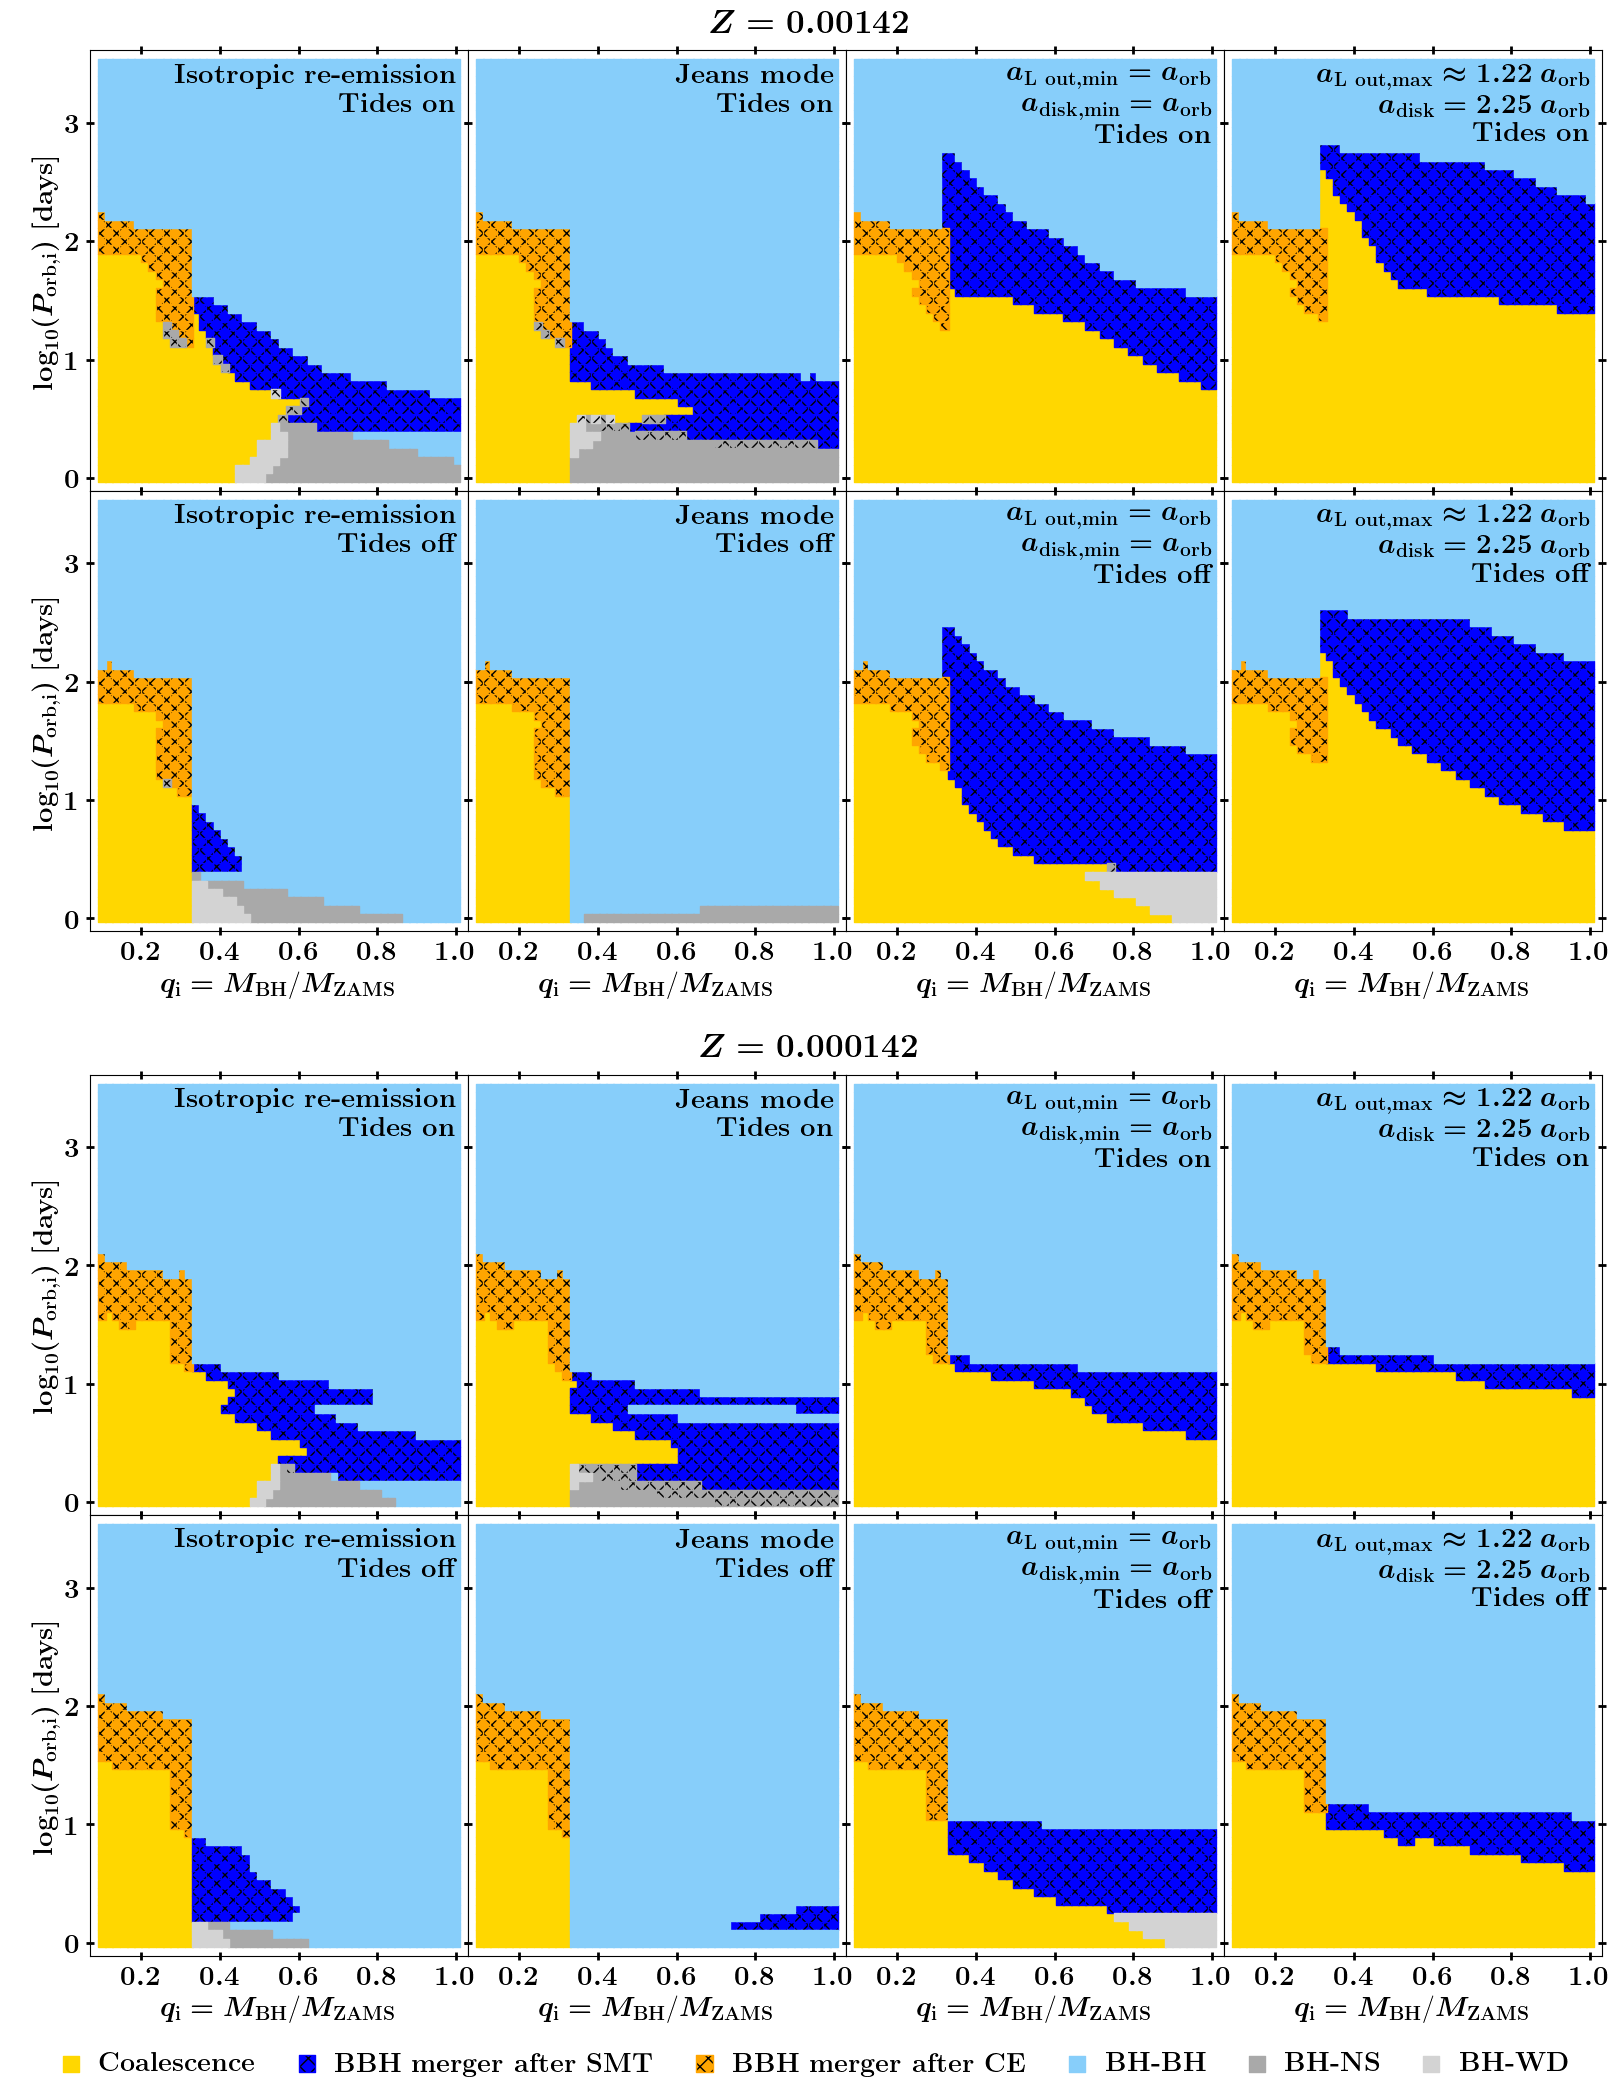

In [6]:
SEVN_dict_list = [dict_fid_isotropic,dict_fid_Jeans, dict_fid_circ100, dict_fid_circ150,
                  dict_notid_isotropic,dict_notid_Jeans,dict_notid_circ100, dict_notid_circ150]
text_input_list8 = [r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides on}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides on}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides on}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+'\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$' +'\n'+r'\textbf{Tides on}',
                   r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides off}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides off}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides off}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+ '\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$'+'\n'+r'\textbf{Tides off}',]
plot_grid_multi8_2Z(m1, Zs, qgrid,Pgrid, SEVN_dict_list, text_input_list8, savename='fidGG',type='gg')

## Fiducial SEVN setup, i.e. GG+21 but with qcrit Hradiative stable in place of Belczynski, keeping lambda=-2 as pure Clayes

In [3]:
dict_fidSEVN_isotropic = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1", 
                    "star_lambda" : "-2",               # i.e. as in BSE, default in SEVN (-2 would be Clayes+2014)
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }


dict_fidSEVN_Jeans = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_fidSEVN_circ100 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }



dict_fidSEVN_circ150 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


In [4]:
dict_notidSEVN_isotropic = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }

dict_notidSEVN_Jeans = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides   
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_notidSEVN_circ100 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


dict_notidSEVN_circ150 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides   
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }

## problematic binary
The following binary, for some reason, keeps running and does not stop. The check_stalling option apparently does not stop the binary in the wrapper. So, I will remove it manually and flag it as merged in every set with the following assumptions
- Jeans mode for angular momentum loss
- tides on
- Z=0.000142
- qcrit_Hradiative_stable

So far, other options do not show problems

In [9]:
print('Jeans_tides_qcrs')
print ('q', np.linspace(0.1,1,50)[7:8])          # mass ratio
print('p [days]', np.logspace(0.0,3.5,50)[1:2])  # period

Jeans_tides_qcrs
q [0.22857143]
p [days] [1.17876863]


/home/erika/miniconda3/envs/SEVN_25ago/lib/python3.12/site-packages/SEVNpy-0.3.2-py3.12-linux-x86_64.egg/sevnpy/sevn/sevnmanager.py:287: RuntimeWarning: Calling initialise of an already initialised SEVN instance. We are finalising the object before reinitialising it
  sw.sevnio_initialise(SEVNmanager._sevnParams)


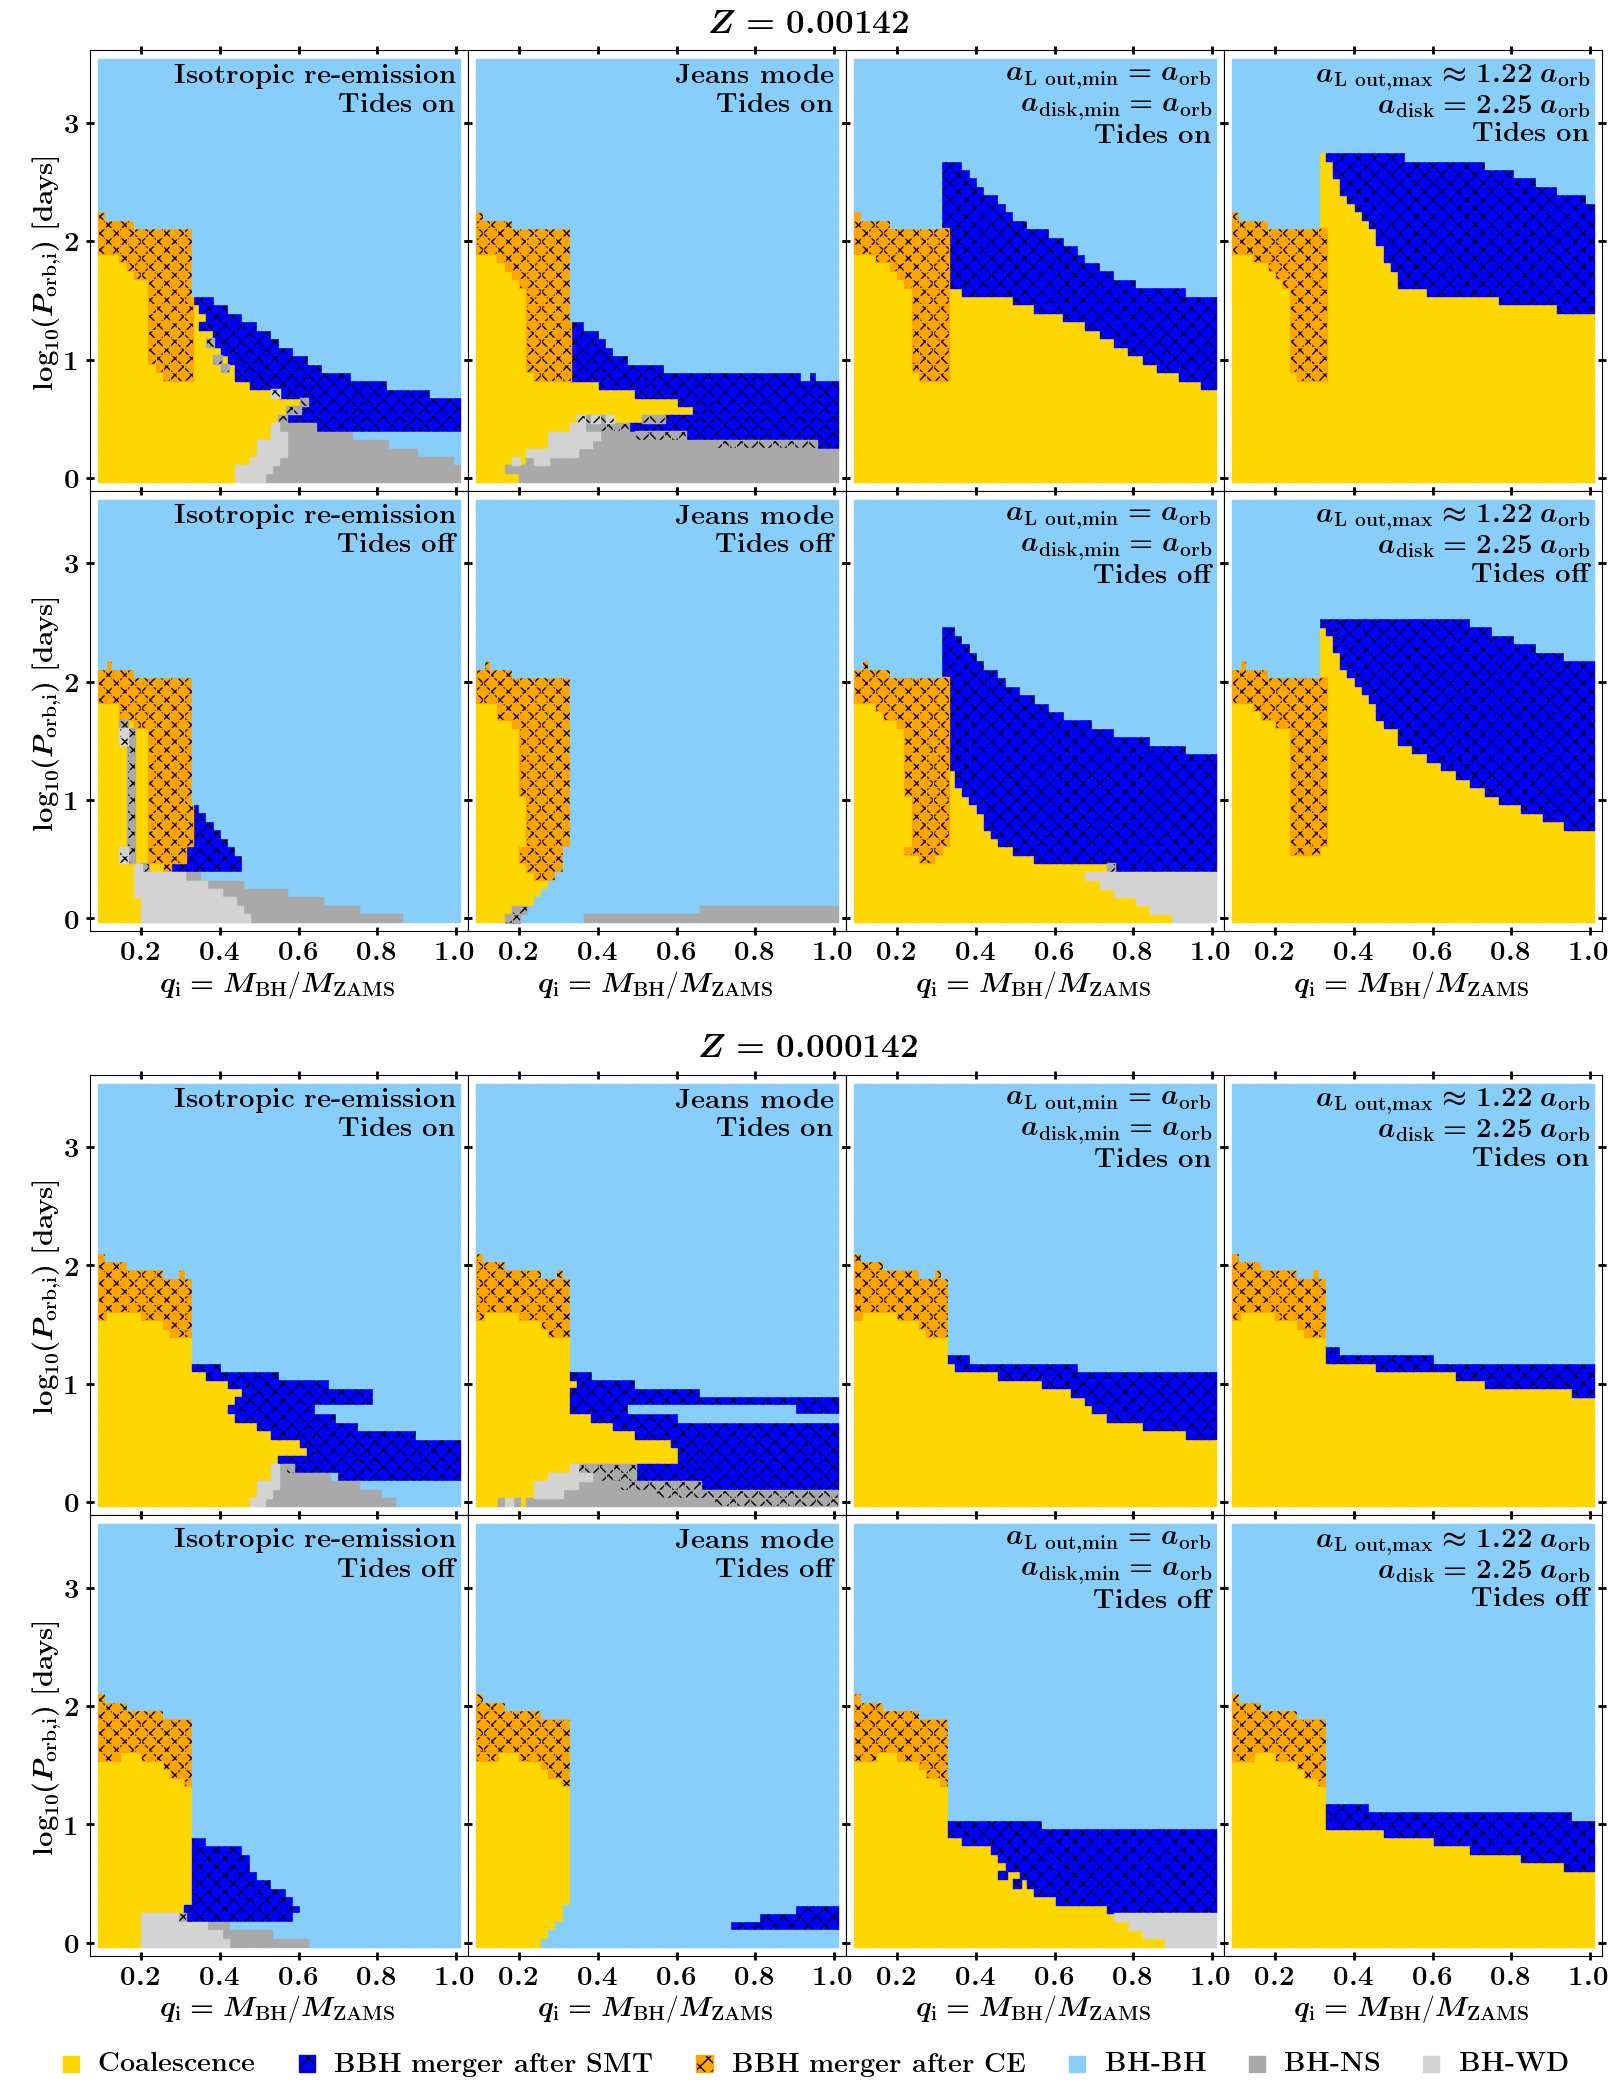

In [23]:
SEVN_dict_list = [dict_fidSEVN_isotropic,dict_fidSEVN_Jeans, dict_fidSEVN_circ100, dict_fidSEVN_circ150,
                  dict_notidSEVN_isotropic,dict_notidSEVN_Jeans,dict_notidSEVN_circ100, dict_notidSEVN_circ150]
text_input_list8 = [r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides on}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides on}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides on}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+'\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$' +'\n'+r'\textbf{Tides on}',
                   r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides off}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides off}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides off}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+ '\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$'+'\n'+r'\textbf{Tides off}',]
plot_grid_multi8_2Z(m1, Zs, qgrid,Pgrid, SEVN_dict_list, text_input_list8, savename='fidSEVN',type='gg',stall_set='Jeans_tides_qcrs')

## SEVN setup with both qcrit Hradiative stable and lambda Claeys+2014 but with the BSE-like setup (as in Iorio+23)

In [11]:
dict_fidSEVNBSE_isotropic = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1", 
                    "star_lambda" : "-1",               # i.e. as in BSE, default in SEVN (-2 would be Clayes+2014)
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }


dict_fidSEVNBSE_Jeans = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-1",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_fidSEVNBSE_circ100 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-1",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


dict_fidSEVNBSE_circ150 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-1",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


In [12]:
dict_notidSEVNBSE_isotropic = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-1",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }

dict_notidSEVNBSE_Jeans = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides   
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-1",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_notidSEVNBSE_circ100 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-1",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


dict_notidSEVNBSE_circ150 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides   
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":True, 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":False,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_Hradiative_stable",   # default SEVN, i.e. QCRS as in Iorio+23
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-1",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }

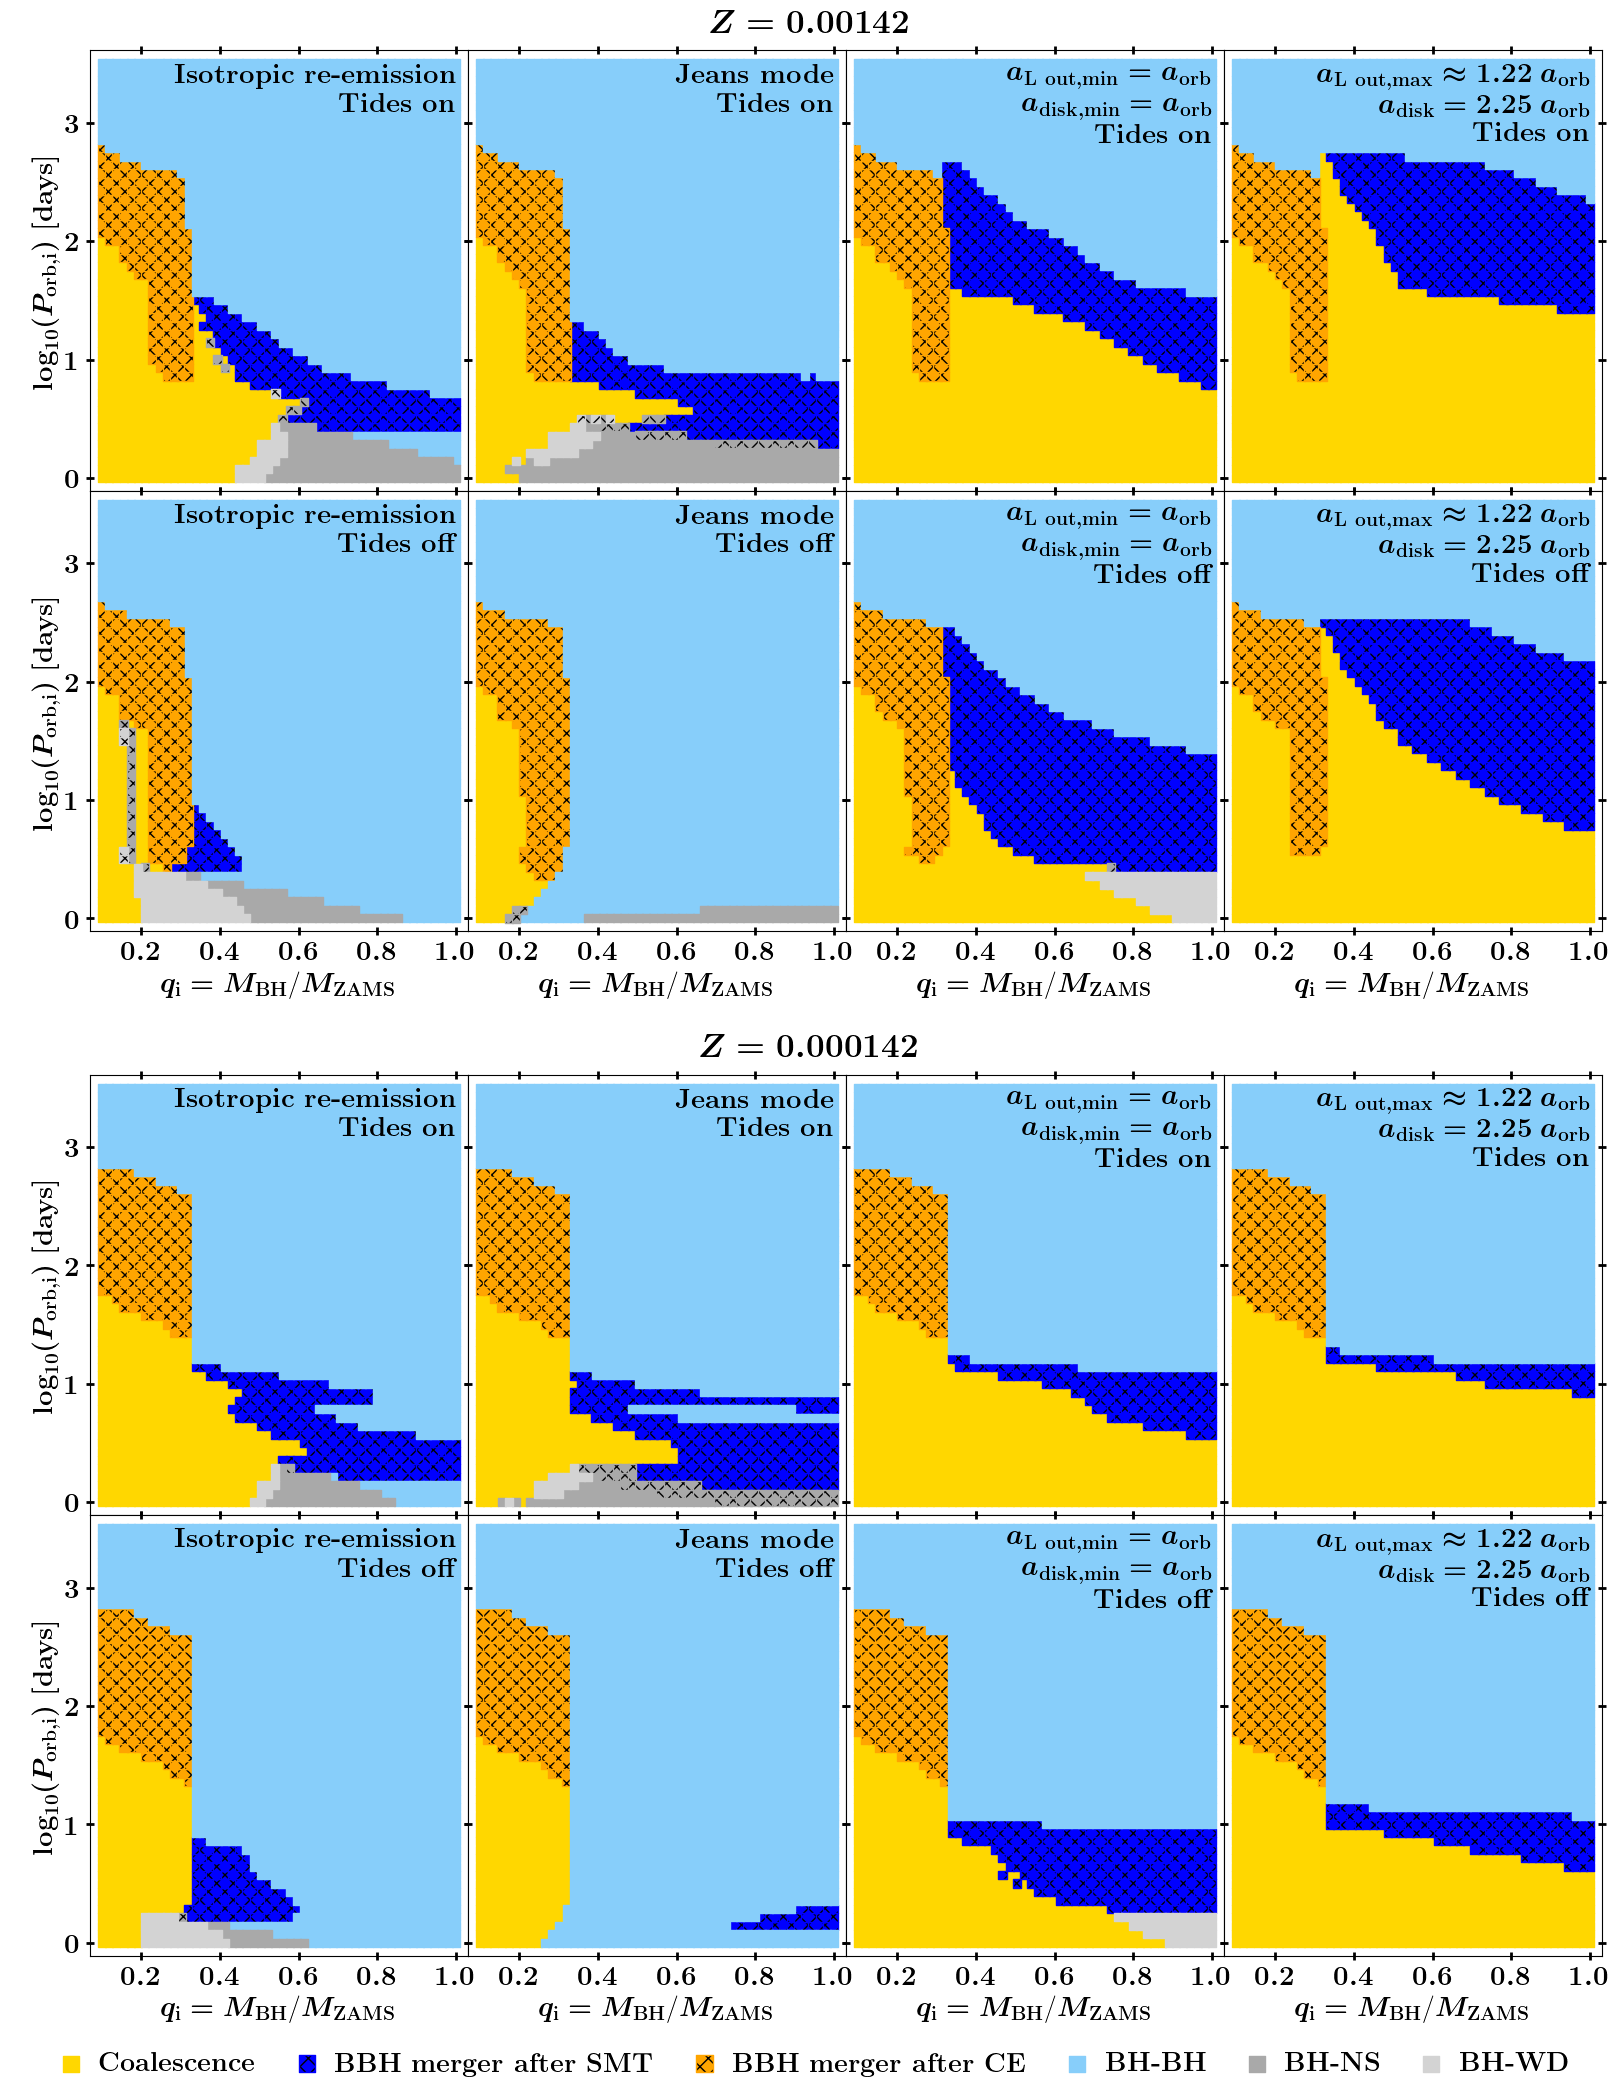

In [24]:
SEVN_dict_list = [dict_fidSEVNBSE_isotropic,dict_fidSEVNBSE_Jeans, dict_fidSEVNBSE_circ100, dict_fidSEVNBSE_circ150,
                  dict_notidSEVNBSE_isotropic,dict_notidSEVNBSE_Jeans,dict_notidSEVNBSE_circ100, dict_notidSEVNBSE_circ150]
text_input_list8 = [r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides on}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides on}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides on}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+'\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$' +'\n'+r'\textbf{Tides on}',
                   r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides off}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides off}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides off}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+ '\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$'+'\n'+r'\textbf{Tides off}',]
plot_grid_multi8_2Z(m1, Zs, qgrid,Pgrid, SEVN_dict_list, text_input_list8, savename='fidSEVNBSE',type='gg',stall_set='Jeans_tides_qcrs')

## Fiducial GG+21 setup but remove convective tables

In [14]:
dict_fidnoconv_isotropic = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,             # disable convective tables
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",                # lambda = -2 i.e. Claeys+2014 "pure"
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }


dict_fidnoconv_Jeans = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,                # disable convective tables
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_fidnoconv_circ100 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,            # disable convective tables
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


dict_fidnoconv_circ150 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,             # disable convective tables
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


In [15]:
dict_notidnoconv_isotropic = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,            # disable convective tables
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }


dict_notidnoconv_Jeans = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,              # disable convective tables
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_notidnoconv_circ100 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,              # disable convective tables 
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }




dict_notidnoconv_circ150 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": parsec_ov05,
                    "tabuse_envconv":False,             # disable convective tables
                    "tabuse_rhe":True,   
                    "tabuse_rco":True,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


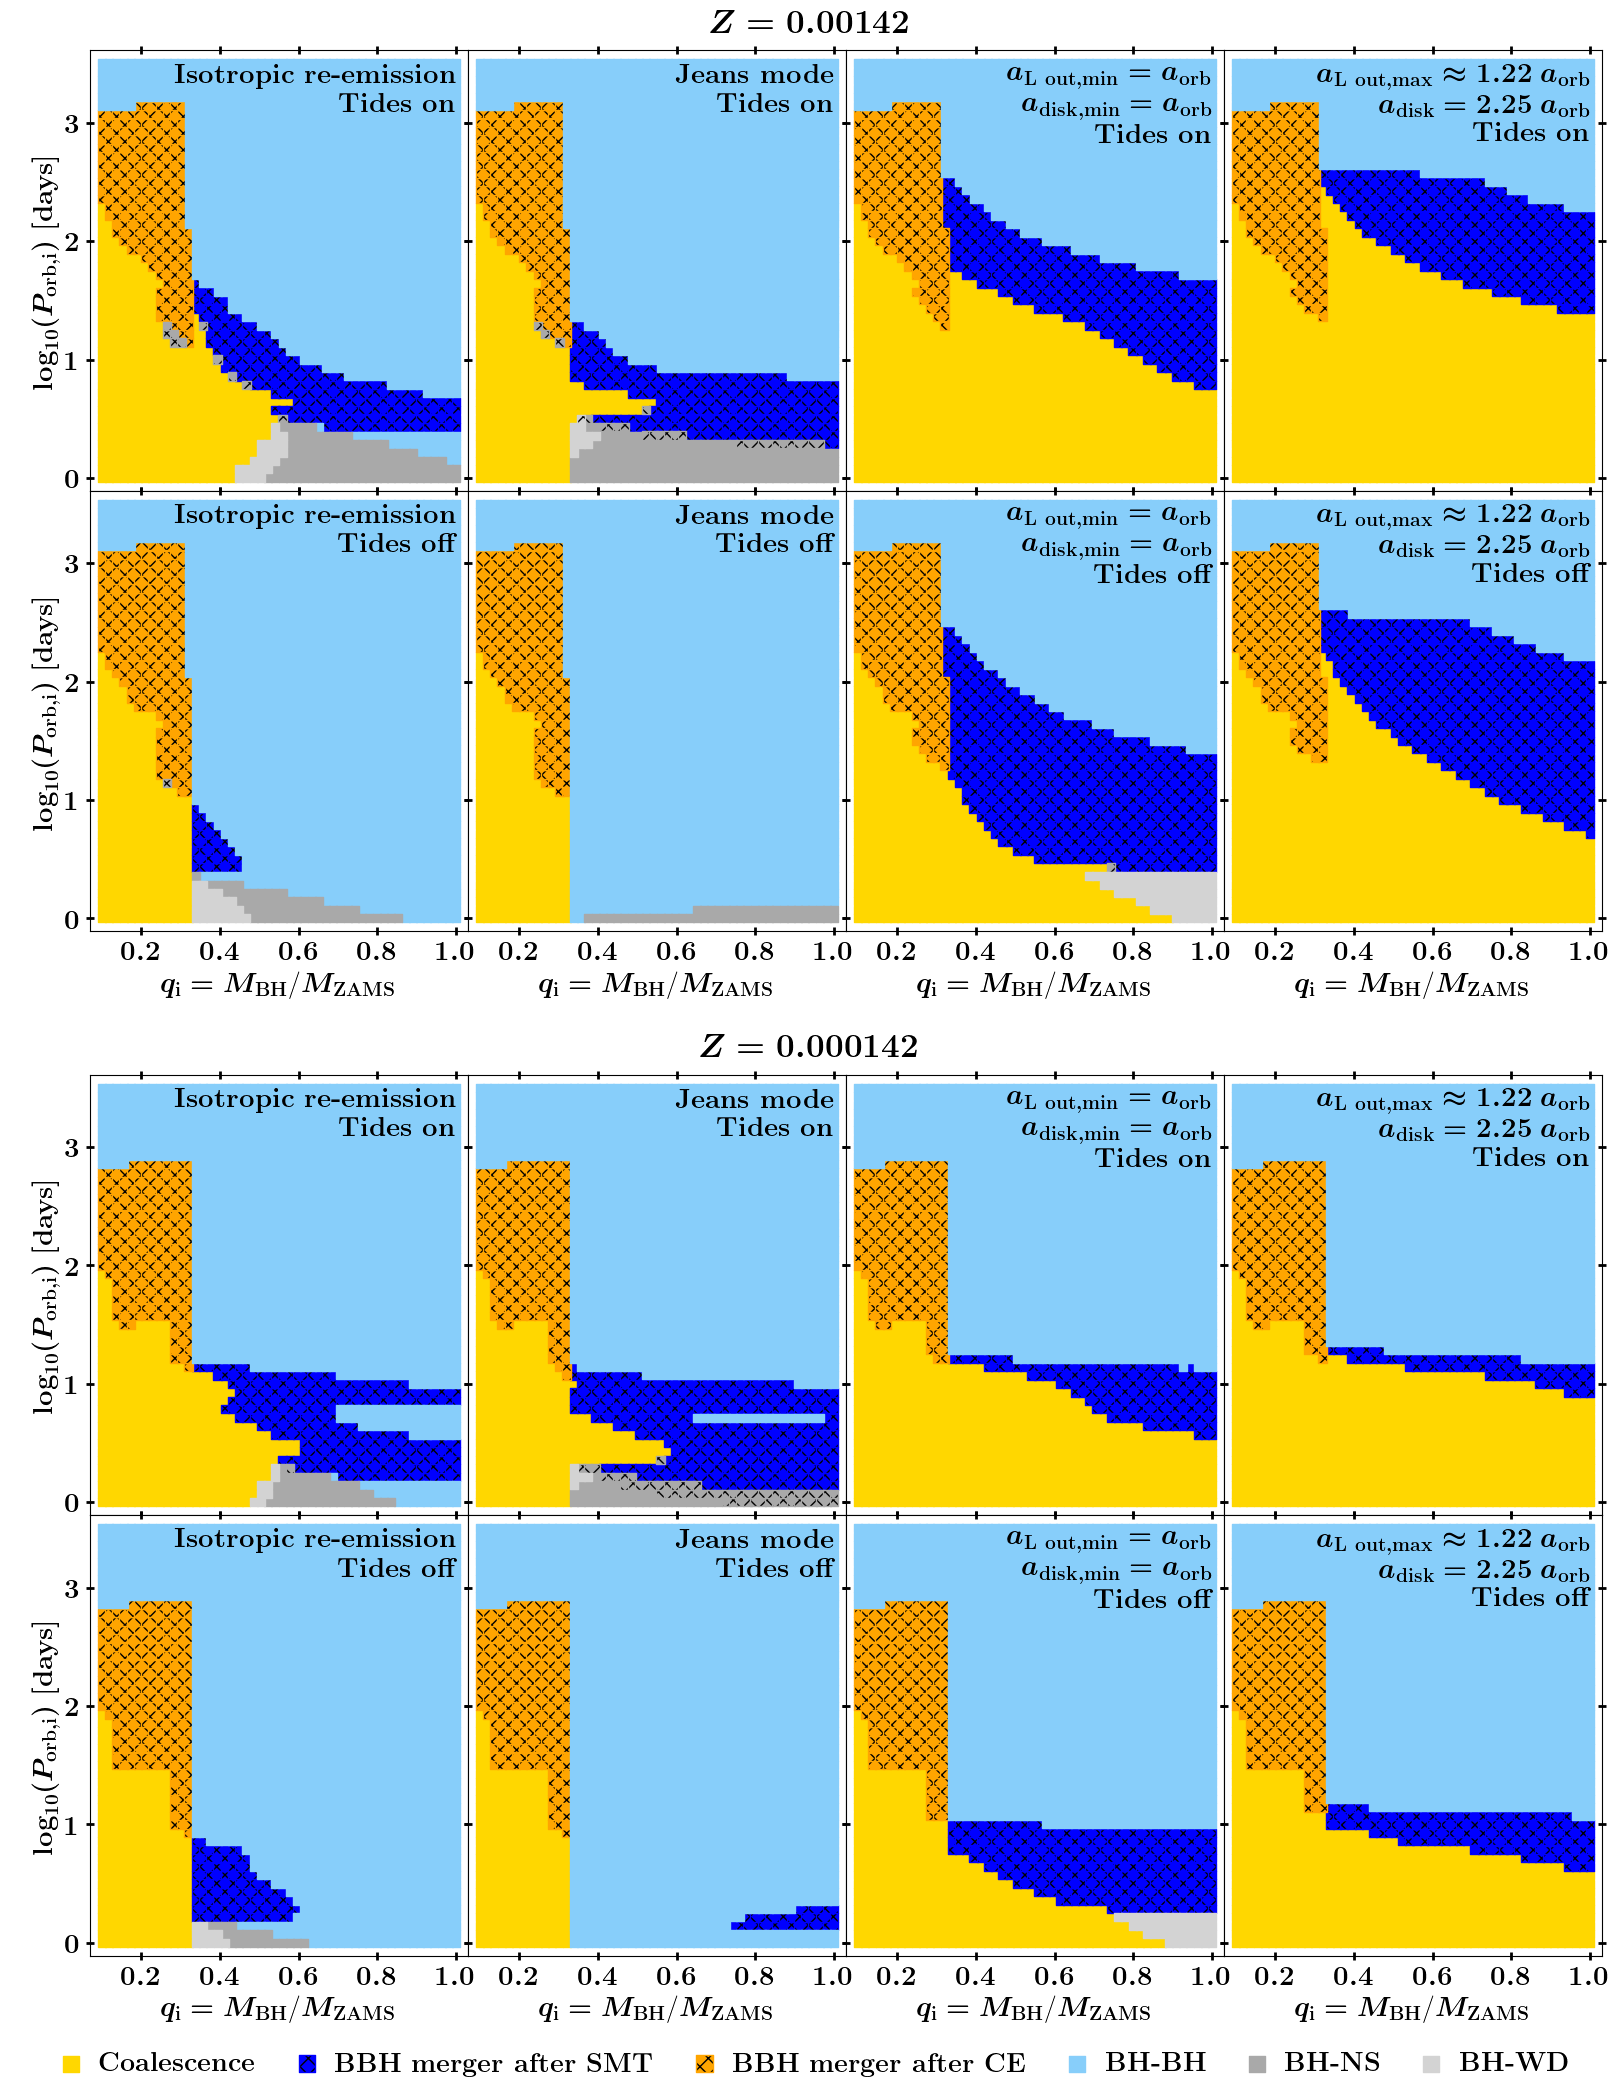

In [16]:
SEVN_dict_list = [dict_fidnoconv_isotropic,dict_fidnoconv_Jeans, dict_fidnoconv_circ100, dict_fidnoconv_circ150,
                  dict_notidnoconv_isotropic,dict_notidnoconv_Jeans,dict_notidnoconv_circ100, dict_notidnoconv_circ150]
text_input_list8 = [r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides on}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides on}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides on}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+'\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$' +'\n'+r'\textbf{Tides on}',
                   r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides off}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides off}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides off}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+ '\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$'+'\n'+r'\textbf{Tides off}',]
plot_grid_multi8_2Z(m1, Zs, qgrid,Pgrid, SEVN_dict_list, text_input_list8, savename='fidnoconv',type='gg',stall_set='')

# Fiducial GG+21 setup but with MIST

In [9]:
dict_fidMIST_isotropic = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,             
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",                # lambda = -2 i.e. Claeys+2014 "pure"
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }


dict_fidMIST_Jeans = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,             
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_fidMIST_circ100 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple    
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,             
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


dict_fidMIST_circ150 = { "wmode" : "hurley",
                    "tmode" : "simple",              # tides simple
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,             
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


In [10]:
dict_notidMIST_isotropic = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,            # disable convective tables
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -2.0            # default SEVN i.e. isotropic re-emission from secondary: gamma=(Mdonor*Mdonor)/(Mtot*Mtot)
                     }


dict_notidMIST_Jeans = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,            # disable convective tables
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": -1.0            # Jeans option i.e. from primary: gamma=(Maccretor*Maccretor)/(Mtot*Mtot)
                     }

dict_notidMIST_circ100 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,            # disable convective tables
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.0            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


dict_notidMIST_circ150 = { "wmode" : "hurley",
                    "tmode" : "disabled",              # no tides
                    "rlmode" : "hurley_rl",
                    "circmode" : "periastron",
                    "sn_kicks" : "zeros",
                    "tables": MIST_robust,
                    "tabuse_envconv":False,            # disable convective tables
                    "tabuse_rhe":False,   
                    "tabuse_rco":False,   
                    'tabuse_inertia': False,            # if False uses Hurley+2000 inertia (default)
                    "use_thg_hurley":True,             # True only if convective tables disabled
                    "optimistic_scenario_hg": True,    
                    "rlo_stability": "qcrit_startrack",
                    "eddington_factor": "1",
                    "w_alpha": "1.5",
                    "w_beta": "0.125",
                    "ce_alpha": "1",
                    "star_lambda" : "-2",
                    "ts_check_spin": True,
                    "ts_check_spin_bse": True,
                     "rlo_gamma_angmom": 1.50            # fraction of specific orbital angular momentum lost to the circumbinary disk / as L2 outflow
                     }


In [7]:
def plot_grid_multi8_1Z(m1, Zs, qgrid,Pgrid, SEVN_dict_list, text_input_list, savename, type='gg', stall_set=''):
    
    plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\boldmath",
    "font.family": "cmr10",   # computer modern font, as in latex
    "axes.formatter.use_mathtext": True,
    "font.size": 20,
    "font.weight": "bold",
    "axes.labelsize" : 20,
    "xtick.labelsize" : 20,
    "ytick.labelsize" : 20,
    "legend.fontsize": 19.5
    })

    nrows_subplots= 2
    ncols_subplots = 4
    fig=plt.figure(figsize=(16,10))   
    subfigs = fig.subfigures(nrows=2, ncols=1,height_ratios=[1,0.05])  # second row is the space for legend
    for subfig, Z in zip(subfigs,Zs):
        axs=subfig.subplots(nrows_subplots,ncols_subplots, sharex=True, sharey=True)
        subfig.suptitle(rf'$Z={Z}$', weight='bold')
        for i,ax, SEVN_dict, text_input in zip(np.arange(len(axs.flat)), axs.flat, SEVN_dict_list, text_input_list):
            # remove the "endless binary" only for the Jeans set (i=1) if all the other conditions are met
            if (stall_set == 'Jeans_tides_qcrs') and (Z==0.000142) and (i == 1):                    
                plot_grid_single(m1, Z, qgrid,Pgrid, SEVN_dict, ax, text_input, type,stall_set)
            else:
                plot_grid_single(m1, Z, qgrid,Pgrid, SEVN_dict, ax, text_input, type, stall_set = '')
                
        for nrow in np.arange(nrows_subplots):    
            axs[nrow][0].set_ylabel(r"$\log_{10} (P_{\rm orb, i}) $ \textbf{[days]}", weight='bold')                          
            for ncol in np.arange(ncols_subplots):            
                axs[nrows_subplots-1][ncol].set_xlabel(r"$q_{\rm i} = M_{\rm BH}$/$M_{\rm ZAMS}$",weight='bold')    
        axs[0][0].set_xlim(xmin = 0.07, xmax = 1.03)
        axs[0][0].set_ylim(ymin = -0.11, ymax = 3.61)
        subfig.subplots_adjust(bottom=0.08,left=0.05,right=0.995,top=0.94, hspace=0, wspace=0)
    handles, labels = axs[0][0].get_legend_handles_labels()
    subfig.legend(handles, labels, ncol=6, columnspacing=0.85, bbox_to_anchor=(0.99,0.01),frameon=False, prop = {'weight':'bold'}, markerscale=2,handletextpad=0.05)
    plt.show()
    fig.savefig(f'/home/erika/Scrivania/uni/1-2dott/paper/GallegosGarciaLike/analysis/popsynth-comparison/server/v_{sevn_version}/plot_grids/multi8_{savename}.pdf',dpi=300)

### MIST tracks are badly interpolated/missing at Z=0.000142, so do not use them

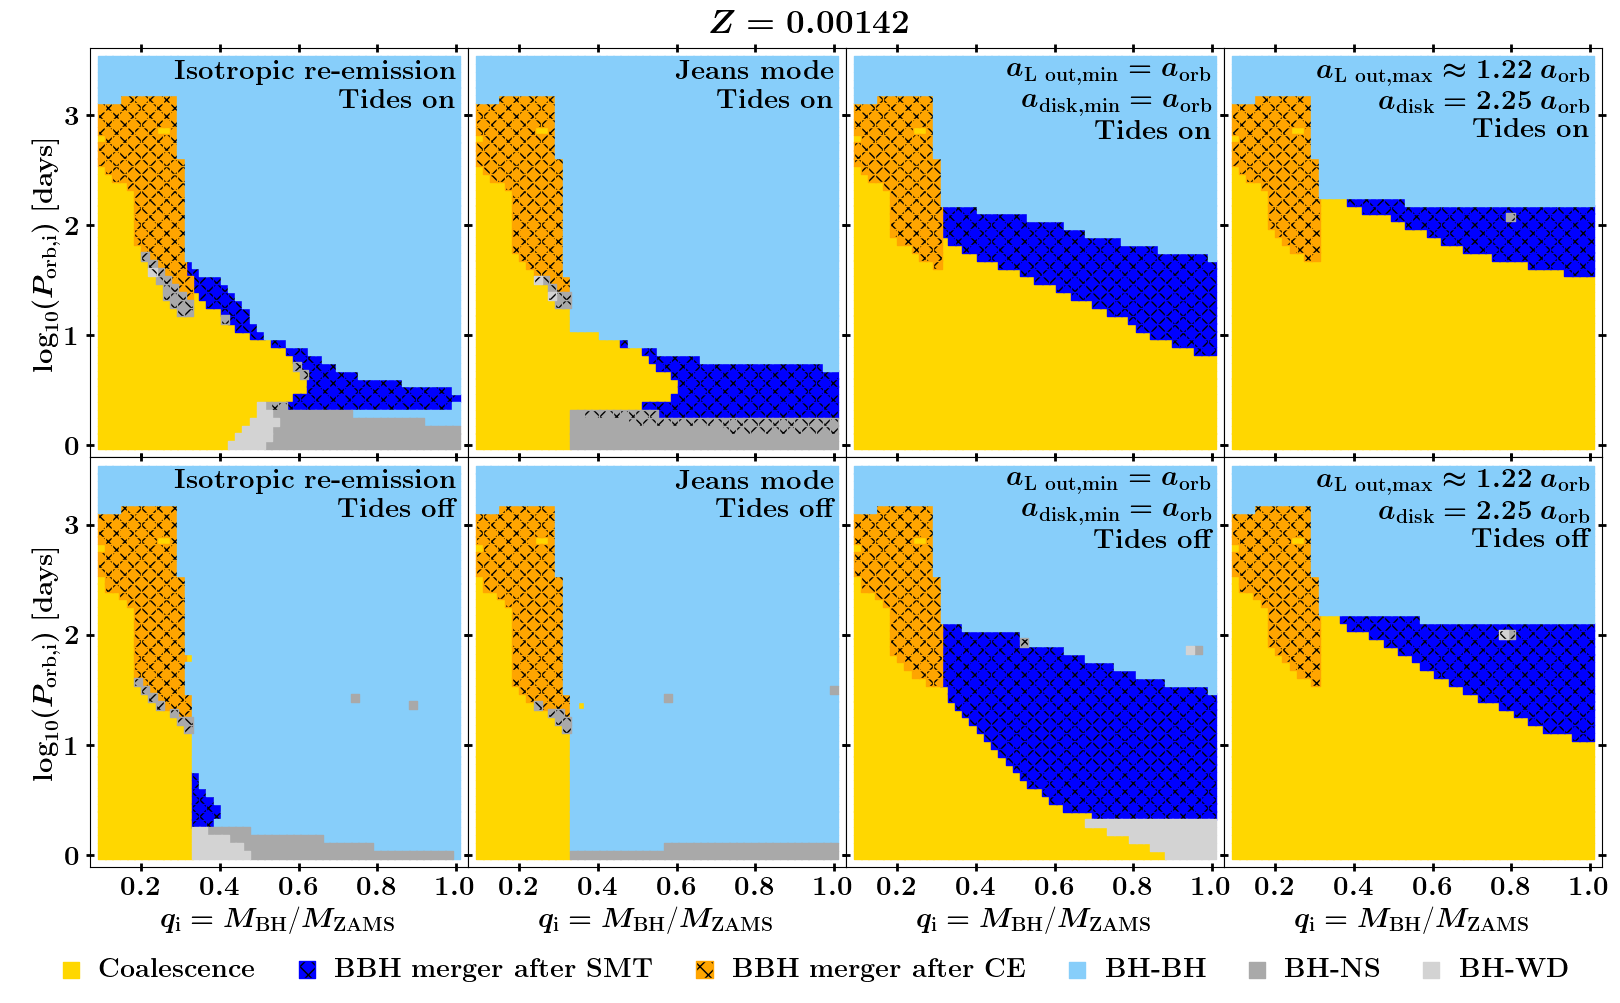

In [13]:
# grid setup
qgrid = np.linspace(0.1,1,50)     # mass ratio
Pgrid = np.logspace(0.0,3.5,50)      # period
m1 = 40                 # Msun, donor mass
Zs = [0.00142]

SEVN_dict_list = [dict_fidMIST_isotropic,dict_fidMIST_Jeans, dict_fidMIST_circ100, dict_fidMIST_circ150,
                  dict_notidMIST_isotropic,dict_notidMIST_Jeans,dict_notidMIST_circ100, dict_notidMIST_circ150]
text_input_list8 = [r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides on}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides on}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides on}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+'\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$' +'\n'+r'\textbf{Tides on}',
                   r'\textbf{Isotropic re-emission}' +'\n'+r'\textbf{Tides off}', r'\textbf{Jeans mode}' +'\n'+r'\textbf{Tides off}',r' $a_{\rm L~out, min} = a_{\rm orb}$'+'\n'+r'$a_{\rm disk,min} = a_{\rm orb}$' +'\n'+r'\textbf{Tides off}', r'$a_{\rm L~out, max} \approx 1.22~a_{\rm orb}$ '+ '\n'+r'$a_{\rm disk} = 2.25~a_{\rm orb}$'+'\n'+r'\textbf{Tides off}',]
plot_grid_multi8_1Z(m1, Zs, qgrid,Pgrid, SEVN_dict_list, text_input_list8, savename='fidMIST',type='gg',stall_set='')